In [ ]:
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import image
import matplotlib.pyplot as plt
from matplotlib import style
import tensorflow as tf
from os import listdir

style.use('dark_background')


<h3> Set memory growth for experimental features </h3>

In [3]:


physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)



<h3> Load Data </h3>

In [4]:


#Load labels from csv
label = pd.read_csv('pokemon.csv')
label = label.sort_values(by = 'Name', ascending=True)
label2 = label.loc[(label.Type1 == 'Grass') | (label.Type1 == 'Water')]

grass_water_names = np.array(label2['Name'])
#Load all images from directory
pokemon_data = []
image_dir = 'images/images'
for name in grass_water_names:
    pokemon_sprite = image.imread(image_dir + '/' + name + '.png')
    pokemon_sprite_rgb = np.full([120, 120, 3], 1, dtype=np.float32)
    for h in range(0,120):
        for w in range(0,120):
            for d in range(0,3):
                if(pokemon_sprite[h][w][3] != 0):
                    pokemon_sprite_rgb[h][w][d] = pokemon_sprite[h][w][d]
    pokemon_data.append(pokemon_sprite_rgb)
    
# convert list to numpy array  
pokemon_data = np.array(pokemon_data).astype(np.float32)

types = np.array(label2['Type1'])
# only using primary pokemon type
all_types = np.array(label['Type1'])


<h3> Encoding and Spliting Data </h3>

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder



enc = LabelEncoder()
enc.fit(types)
types = enc.transform(types)


X_train, X_test, y_train, y_test = train_test_split(pokemon_data, types, test_size = 0.3, random_state = 4)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


print(y_train)

[0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 1 1 1 1 1
 1 0 1 1 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 1 1 1 1
 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0 0
 1 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1]


7 first training images


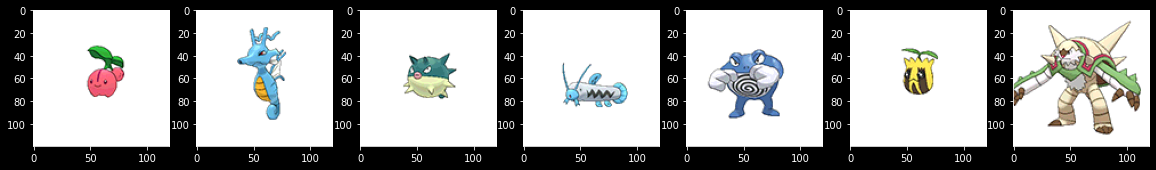

In [43]:
def show_image(data_slice, img_count):
    print("{} first training images".format(img_count))
    plt.figure(figsize=(20,3))
    for i in range(0, img_count):
        plt.subplot(1, img_count, i+1)
        plt.imshow(data_slice[i])
    
show_image(X_train, 7)

<h3> Data Normalization and Augmentation </h3>

In [28]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#normalizing data
X_train /= 255.0
X_test /= 255.0

augmentation_layers = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal_and_vertical"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomTranslation(0.2, 0.2)
])

<h3> Defining Model </h3>

In [29]:
#Custom CNN model

model = tf.keras.Sequential()
model.add(augmentation_layers)
model.add(layers.Conv2D(32, (3, 3), strides = (1, 1), padding = 'same', activation = 'relu', input_shape=(120, 120, 3) ))
model.add(layers.MaxPooling2D((2, 2), strides = (1, 1), padding = 'same'))
#model.add(layers.Dropout(0.2))
          
model.add(layers.Conv2D(128, (3, 3), strides = (1, 1), padding = 'same', activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2), strides = (1, 1), padding = 'same'))
#model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3), strides = (1, 1), padding = 'same', activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2), strides = (1, 1), padding = 'same'))
#model.add(layers.Dropout(0.2))
    
    
model.add(layers.Flatten())
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
    

model.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy(), metrics = [ tf.keras.metrics.BinaryAccuracy()])


<h3> Optimizing and Fitting Model </h3>

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

#early stop when validation accuracy drops
early_stop = EarlyStopping(min_delta = 0.001, patience = 30, restore_best_weights = True)

trained_model = model.fit(X_train, y_train,
                    batch_size = 64,
                    validation_data = (X_test, y_test),
                    shuffle = True,
                    callbacks = [early_stop],
                    epochs = 20
                   )

Epoch 1/20
3/3 [==============================] - 2s 148ms/step - loss: 0.6790 - binary_accuracy: 0.5821 - val_loss: 0.7449 - val_binary_accuracy: 0.5690
Epoch 2/20
3/3 [==============================] - 0s 65ms/step - loss: 0.7058 - binary_accuracy: 0.6045 - val_loss: 0.6912 - val_binary_accuracy: 0.5690
Epoch 3/20
3/3 [==============================] - 0s 64ms/step - loss: 0.6865 - binary_accuracy: 0.6045 - val_loss: 0.6837 - val_binary_accuracy: 0.5690
Epoch 4/20
3/3 [==============================] - 0s 65ms/step - loss: 0.6688 - binary_accuracy: 0.6045 - val_loss: 0.7201 - val_binary_accuracy: 0.5690
Epoch 5/20
3/3 [==============================] - 0s 64ms/step - loss: 0.6907 - binary_accuracy: 0.6045 - val_loss: 0.7074 - val_binary_accuracy: 0.5690
Epoch 6/20
3/3 [==============================] - 0s 65ms/step - loss: 0.6779 - binary_accuracy: 0.6045 - val_loss: 0.6872 - val_binary_accuracy: 0.5690
Epoch 7/20
3/3 [==============================] - 0s 63ms/step - loss: 0.6699 - b

<h3> Validation and Prediction </h3>

2/2 [==============================] - 0s 10ms/step - loss: 0.6838 - binary_accuracy: 0.5690
Accuracy: 0.568965494632721


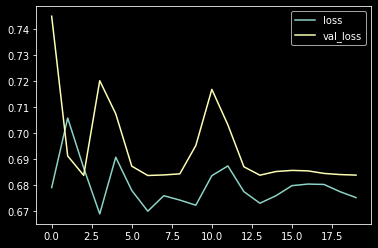

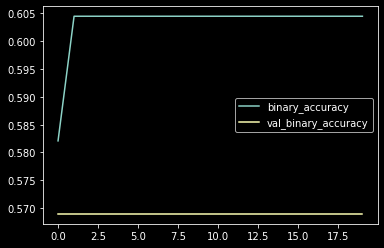

In [31]:
history_frame = pd.DataFrame(trained_model.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

loss, model_accuracy = model.evaluate(X_test, y_test)

print("Accuracy:", model_accuracy)

In [33]:

model.predict(X_train)


array([[0.57811624],
       [0.5781438 ],
       [0.57813   ],
       [0.5781415 ],
       [0.57814944],
       [0.57813305],
       [0.5782051 ],
       [0.5781637 ],
       [0.578144  ],
       [0.57812816],
       [0.5781516 ],
       [0.5781421 ],
       [0.57812554],
       [0.5781538 ],
       [0.57815045],
       [0.5781699 ],
       [0.5781341 ],
       [0.5781479 ],
       [0.57813305],
       [0.57810086],
       [0.57814944],
       [0.5781613 ],
       [0.5781495 ],
       [0.57814246],
       [0.5781283 ],
       [0.57813406],
       [0.5781364 ],
       [0.5781398 ],
       [0.5781611 ],
       [0.57812023],
       [0.5781664 ],
       [0.5781517 ],
       [0.5781593 ],
       [0.57814765],
       [0.5781362 ],
       [0.57816094],
       [0.57812816],
       [0.5781333 ],
       [0.5781441 ],
       [0.57816297],
       [0.5781237 ],
       [0.57814246],
       [0.57812464],
       [0.5781623 ],
       [0.5781367 ],
       [0.5781549 ],
       [0.57815593],
       [0.578